Data Engineering

In [68]:
# Extract Data from csv
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np

model_names = ["Logistic_Regression", "Decision_Tree", "Random_Forest", "XGBoost", 
            "SVC", "KNN", "Naive_Bayes", "Neural_Network", "Gradient_Boosting", "Voting_Classifier", "KMeans"]
metrics = ["accuracy", "precision", "recall", "f1_score"]

models_name = []

metrics_train = {}
metrics_test = {}

# metrics
for model in model_names:
    for metric in metrics:
        metrics_train[f"{metric}_{model}"] = []
        metrics_test[f"{metric}_{model}"] = []

models = []

# Load dataset
data = pd.read_csv("over_features.csv")

# take only first 2000 rows
data = data.iloc[:2000]

# Check for missing values
print("Missing values in data:")
print(data.isnull().sum())

# Remove rows with missing values
data.dropna(inplace=True)

# remove identifier
data = data.drop(columns=["match_id"])

# Encode 'team' column with numbers
team_mapping = {team: idx for idx, team in enumerate(data["team"].unique())}
data["team_encoded"] = data["team"].map(team_mapping)

# Encode 'match_phase' column with numbers
phase_mapping = {phase: idx for idx, phase in enumerate(data["match_phase"].unique())}
data["match_phase_encoded"] = data["match_phase"].map(phase_mapping)

# Drop original categorical columns
X_encoded = data.drop(columns=["team", "match_phase"])

# Train-test split
train_data, test_data = train_test_split(X_encoded, test_size=0.2, random_state=42)

# Split x and y
X_train = train_data.drop(columns=["wicket_next_over"])
y_train = train_data["wicket_next_over"]

X_test = test_data.drop(columns=["wicket_next_over"])
y_test = test_data["wicket_next_over"]

# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Missing values in data:
match_id                             0
innings                              0
team                                 0
over                                 0
balls_faced_by_striker               0
striker_strike_rate                  0
striker_boundaries_hit               0
dot_ball_pressure                    0
current_bowler_economy               0
bowler_wickets_in_match              0
total_overs_completed                0
overs_since_last_wicket              0
number_of_wickets_lost               0
required_desired_run_rate            0
current_run_rate                     0
wickets_lost_last_3_overs            0
number_of_boundaries_last_3_overs    0
number_of_dot_balls_last_over        0
powerplay_overs_remaining            0
match_phase                          0
wicket_next_over                     0
dtype: int64


In [69]:
# Handle / plot data imbalances
# TODO


Feature Engineering

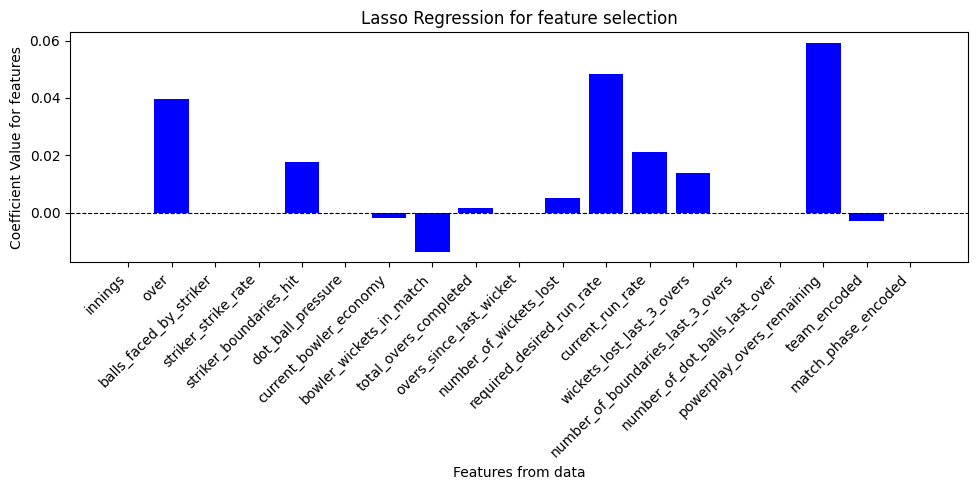

Feature Coefficients: {'innings': 0.0, 'over': 0.039746014053452995, 'balls_faced_by_striker': -0.0, 'striker_strike_rate': -0.0, 'striker_boundaries_hit': 0.01771879643960454, 'dot_ball_pressure': 0.0, 'current_bowler_economy': -0.0019344251056420381, 'bowler_wickets_in_match': -0.013617485048833025, 'total_overs_completed': 0.001664456249094993, 'overs_since_last_wicket': -0.0, 'number_of_wickets_lost': 0.005096217394296881, 'required_desired_run_rate': 0.04845701018314639, 'current_run_rate': 0.02132502986977356, 'wickets_lost_last_3_overs': 0.01402943612063059, 'number_of_boundaries_last_3_overs': -0.0, 'number_of_dot_balls_last_over': 0.0, 'powerplay_overs_remaining': 0.05922011247680646, 'team_encoded': -0.0027611470083892197, 'match_phase_encoded': 0.0}


In [70]:
# Regularization L1, L2, and ElasticNet
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

# Lasso Regression with Grid Search
alphas = np.logspace(-3, 1, 100) 
lasso = Lasso(max_iter=1000)
grid = GridSearchCV(lasso, param_grid={"alpha": alphas}, cv=5, scoring="r2")
grid.fit(X_train_scaled, y_train)

# Best model and feature importance
best_lasso = grid.best_estimator_
lasso_coef = best_lasso.coef_

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.bar(X_train.columns, lasso_coef, color='blue')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.xlabel("Features from data")
plt.ylabel("Coefficient Value for features")
plt.title("Lasso Regression for feature selection")

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Prevent labels from being cut off
plt.tight_layout()

plt.show()

print("Feature Coefficients:", dict(zip(X_train.columns, lasso_coef)))


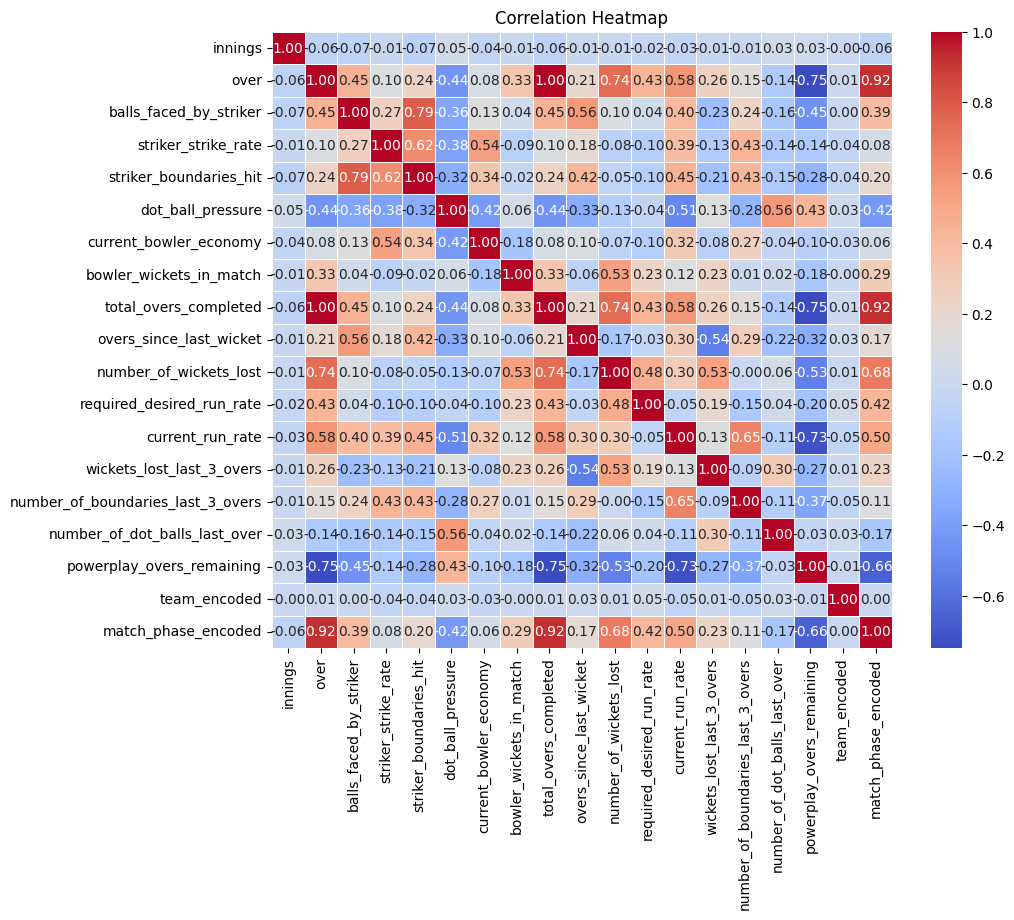

In [71]:
import seaborn as sns

# correlation matrix
correlation_matrix = X_train.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

                              Feature  Importance
3                 striker_strike_rate    0.098472
6              current_bowler_economy    0.097996
11          required_desired_run_rate    0.097424
12                   current_run_rate    0.092117
2              balls_faced_by_striker    0.087237
5                   dot_ball_pressure    0.074021
17                       team_encoded    0.068079
14  number_of_boundaries_last_3_overs    0.048516
1                                over    0.045318
4              striker_boundaries_hit    0.043984
8               total_overs_completed    0.043610
9             overs_since_last_wicket    0.041592
10             number_of_wickets_lost    0.040379
15      number_of_dot_balls_last_over    0.038522
7             bowler_wickets_in_match    0.025255
13          wickets_lost_last_3_overs    0.021633
0                             innings    0.018152
16          powerplay_overs_remaining    0.009551
18                match_phase_encoded    0.008142


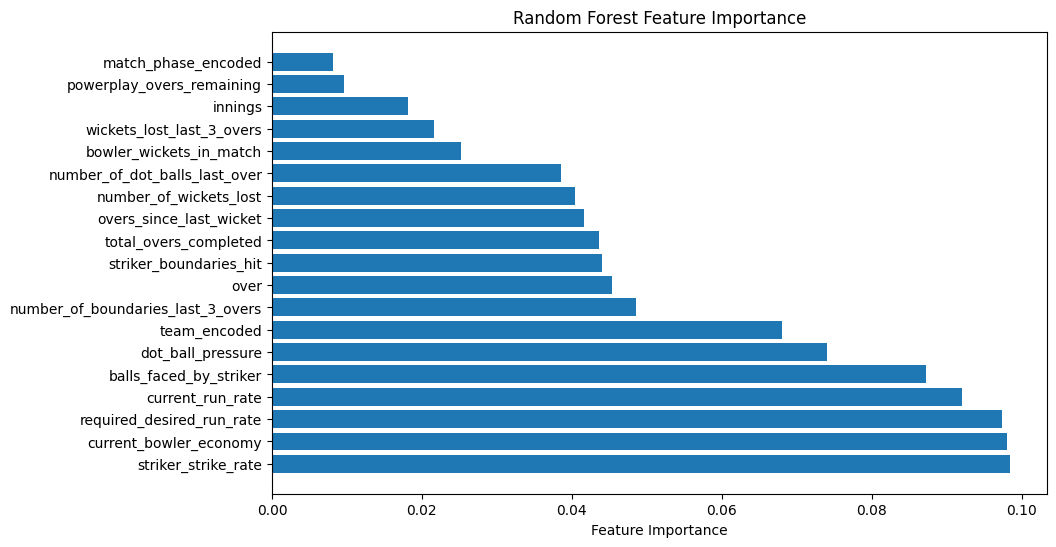

In [72]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Get feature importances
feature_importances = rf.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train.columns,  
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Plotting the feature importance
plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

Model Training

In [73]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return accuracy, precision, recall, f1


def evaluate_model(y_train_true, y_train_pred, y_test_true, y_test_pred, model_name, model):
    # Store model
    models.append(model)
    models_name.append(model_name)

    # Calculate metrics
    accuracy_train, precision_train, recall_train, f1_train = calculate_metrics(y_train_true, y_train_pred)
    accuracy_test, precision_test, recall_test, f1_test = calculate_metrics(y_test_true, y_test_pred)

    # save metrics
    metrics_train[f"accuracy_{model_name}"].append(accuracy_train)
    metrics_train[f"precision_{model_name}"].append(precision_train)
    metrics_train[f"recall_{model_name}"].append(recall_train)
    metrics_train[f"f1_score_{model_name}"].append(f1_train)

    metrics_test[f"accuracy_{model_name}"].append(accuracy_test)
    metrics_test[f"precision_{model_name}"].append(precision_test)
    metrics_test[f"recall_{model_name}"].append(recall_test)
    metrics_test[f"f1_score_{model_name}"].append(f1_test)
    
    cross_validate_model(model, model_name, X_train_scaled, y_train)

def cross_validate_model(model, model_name, X, y, n_splits=5):
    average_metrics_train = {
        "accuracy": 0,
        "precision": 0,
        "recall": 0,
        "f1_score": 0
    }
    
    # Stratified K-Fold Cross-Validation
    k_folds = 0
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_index, test_index in skf.split(X, y):
        k_folds += 1
        
        # If X is a NumPy array
        X = pd.DataFrame(X)

        # If y is a 1D NumPy array
        y = pd.Series(y)
        
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_test_cv)

        # Evaluate the model
        accuracy, precision, recall, f1 = calculate_metrics(y_test_cv, y_pred_cv)
        average_metrics_train["accuracy"] += accuracy
        average_metrics_train["precision"] += precision
        average_metrics_train["recall"] += recall
        average_metrics_train["f1_score"] += f1
        
    metrics_test[f"accuracy_kfold_{model_name}"] = average_metrics_train["accuracy"] / k_folds
    metrics_test[f"precision_kfold_{model_name}"] = average_metrics_train["precision"] / k_folds
    metrics_test[f"recall_kfold_{model_name}"] = average_metrics_train["recall"] / k_folds
    metrics_test[f"f1_score_kfold_{model_name}"] = average_metrics_train["f1_score"] / k_folds

def train_and_evaluate_model(model, model_name):
    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Evaluate the model
    evaluate_model(y_train, y_train_pred, y_test, y_test_pred, model_name, model)

In [74]:
# Logistic Regression model
model = LogisticRegression(multi_class='multinomial', max_iter=1000)

train_and_evaluate_model(model, "Logistic_Regression")

C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5

In [75]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree model
model = DecisionTreeClassifier(random_state=42)

train_and_evaluate_model(model, "Decision_Tree")

In [76]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest model
model = RandomForestClassifier(random_state=42)

train_and_evaluate_model(model, "Random_Forest")

In [77]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(random_state=42)

train_and_evaluate_model(model, "Gradient_Boosting")

In [78]:
# SVM
from sklearn.svm import SVC

model = SVC(random_state=42)

train_and_evaluate_model(model, "SVC")

In [79]:
# KMeans
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2, random_state=42)

train_and_evaluate_model(model, "KMeans")

In [80]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5)

train_and_evaluate_model(model, "KNN")

In [81]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

train_and_evaluate_model(model, "Naive_Bayes")

In [82]:
!pip install xgboost

DEPRECATION: Loading egg at c:\users\andrey\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local-packages\python311\site-packages\imufusion-1.2.5-py3.11-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\Andrey\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [83]:
from xgboost import XGBClassifier

# XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

train_and_evaluate_model(model, "XGBoost")

C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [13:07:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [13:07:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [13:07:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder"

In [84]:
from sklearn.ensemble import VotingClassifier

# Voting Classifier
model = VotingClassifier(estimators=[
    ('logistic', LogisticRegression(multi_class='multinomial', max_iter=1000)),
    ('tree', DecisionTreeClassifier(random_state=42)),
    ('forest', RandomForestClassifier(random_state=42)),
    ('boosting', GradientBoostingClassifier(random_state=42)),
    ('xgboost', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
], voting='soft')

train_and_evaluate_model(model, "Voting_Classifier")

C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [13:07:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1237: Future

In [85]:
!pip install torch


DEPRECATION: Loading egg at c:\users\andrey\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local-packages\python311\site-packages\imufusion-1.2.5-py3.11-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\Andrey\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [91]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Dynamically get the number of input features (columns in X)
num_features = X_train.shape[1]

class ImprovedWicketPredictor(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedWicketPredictor, self).__init__()
        # First hidden layer with more neurons
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)  # Second hidden layer
        self.fc3 = nn.Linear(32, 16)  # Third hidden layer
        self.fc4 = nn.Linear(16, 8)   # Fourth hidden layer
        self.fc5 = nn.Linear(8, 1)    # Output layer

        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer to prevent overfitting

        # Batch Normalization
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.batch_norm2 = nn.BatchNorm1d(32)
        self.batch_norm3 = nn.BatchNorm1d(16)
        self.batch_norm4 = nn.BatchNorm1d(8)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.batch_norm1(x)
        x = self.dropout(x)

        x = self.relu(self.fc2(x))
        x = self.batch_norm2(x)
        x = self.dropout(x)

        x = self.relu(self.fc3(x))
        x = self.batch_norm3(x)
        x = self.dropout(x)

        x = self.relu(self.fc4(x))
        x = self.batch_norm4(x)

        x = self.fc5(x)
        x = self.sigmoid(x)
        return x
    
    
def NN_predict(X_train, X_test, Y_train, Y_test):
    # Convert pandas DataFrames/Series to PyTorch tensors via NumPy
    X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
    y_train_tensor = torch.tensor(Y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
    y_test_tensor = torch.tensor(Y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

    # Create a DataLoader for batch processing (important for large datasets)
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

    # Instantiate the model
    input_dim = X_train.shape[1]
    model = ImprovedWicketPredictor(input_dim)

    # Define the loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    # Training the model with early stopping
    epochs = 100
    best_accuracy = 0
    patience = 10  # Early stopping patience
    no_improvement = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate accuracy on the training set
        with torch.no_grad():
            model.eval()
            y_train_pred = model(X_train_tensor).round()
            accuracy = accuracy_score(y_train_tensor.numpy(), y_train_pred.numpy())
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Training Accuracy: {accuracy:.4f}')

        # Check for early stopping condition
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print("Early stopping triggered.")
            break

    # Evaluate the model on the test set
    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test_tensor).round()
    
    return y_test_pred

y_test_pred = NN_predict(X_train_scaled, X_test_scaled, y_train, y_test)
accuracy, precision, recall, f1 = calculate_metrics(y_test, y_test_pred)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

metrics_test[f"accuracy_Neural_Network"].append(accuracy)
metrics_test[f"precision_Neural_Network"].append(precision)
metrics_test[f"recall_Neural_Network"].append(recall)
metrics_test[f"f1_score_Neural_Network"].append(f1)

def cross_validate_NN(model, model_name, X, y, n_splits=5):
    average_metrics_train = {
        "accuracy": 0,
        "precision": 0,
        "recall": 0,
        "f1_score": 0
    }
    
    # Stratified K-Fold Cross-Validation
    k_folds = 0
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_index, test_index in skf.split(X, y):
        k_folds += 1
        
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
        if isinstance(y, np.ndarray):
            y = pd.Series(y)
        
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        Y_train_cv, Y_test_cv = y.iloc[train_index], y.iloc[test_index]

        y_pred_cv = NN_predict(X_train_cv, X_test_cv, Y_train_cv, Y_test_cv)
        
        # Convert probabilities to binary predictions
        y_pred_binary = (y_pred_cv > 0.5).astype(int)

        # Evaluate the model
        accuracy, precision, recall, f1 = calculate_metrics(Y_test_cv, y_pred_binary)
        average_metrics_train["accuracy"] += accuracy
        average_metrics_train["precision"] += precision
        average_metrics_train["recall"] += recall
        average_metrics_train["f1_score"] += f1
        
    metrics_test[f"accuracy_kfold_{model_name}"] = average_metrics_train["accuracy"] / k_folds
    metrics_test[f"precision_kfold_{model_name}"] = average_metrics_train["precision"] / k_folds
    metrics_test[f"recall_kfold_{model_name}"] = average_metrics_train["recall"] / k_folds
    metrics_test[f"f1_score_kfold_{model_name}"] = average_metrics_train["f1_score"] / k_folds
    
    
X_all_data = X_encoded.drop(columns=["wicket_next_over"])
Y_all_data = X_encoded["wicket_next_over"]

cross_validate_NN(model, "Neural_Network", X_all_data, Y_all_data)



AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [ ]:
def under_or_overfitting(model, under_or_over, model_name):
    sign = 1

    if under_or_over == "underfitting":
            sign = -1
            
    try:
        model.get_params()
    except:
        return model

    params = model.get_params()
    
    # do grid search for the best params
    params = model.get_params()

    # =====================
    # General
    # =====================
    if 'max_iter' in params:
        if (params['max_iter'] + (100 * sign) > 0):
            model.set_params(max_iter=params['max_iter'] + (100 * sign))
            
    if 'penalty' in params:
        if under_or_over == "overfitting":
            if params['penalty'] == 'l2':
                model.set_params(penalty='l1')
            else:
                model.set_params(penalty='l2')

    # =====================
    # Logistic Regression
    # =====================
    if model_name == "Logistic_Regression":
        if 'C' in params:
            if (params['C'] + (0.1 * sign) > 0):
                model.set_params(C=params['C'] + (0.1 * sign))

    # =====================
    # SVC (SVM)
    # =====================
    if model_name == "SVC":
        if 'kernel' in params:
            kernels = ['linear', 'rbf', 'poly', 'sigmoid']
            current_kernel = params['kernel']
            if current_kernel in kernels:
                next_index = (kernels.index(current_kernel) + sign) % len(kernels)
                model.set_params(kernel=kernels[next_index])

        if 'gamma' in params and isinstance(params['gamma'], (int, float)):
            if (params['gamma'] + (0.01 * sign)) > 0:
                model.set_params(gamma=params['gamma'] + (0.01 * sign))

    # =====================
    # Decision Tree / Random Forest / Gradient Boosting
    # =====================
    if model_name in ["Decision_Tree", "Random_Forest", "Gradient_Boost"]:
        if 'max_depth' in params:
            depth = params['max_depth'] if params['max_depth'] is not None else 5
            if depth + (3 * sign) > 0:
                model.set_params(max_depth=depth + (3 * sign))

        if 'min_samples_split' in params:
            val = params['min_samples_split'] if params['min_samples_split'] is not None else 2
            if val + (2 * sign) > 0:
                model.set_params(min_samples_split=val + (2 * sign))

        if 'min_samples_leaf' in params:
            val = params['min_samples_leaf'] if params['min_samples_leaf'] is not None else 1
            if val + (2 * sign) > 0:
                model.set_params(min_samples_leaf=val + (2 * sign))

        if 'max_features' in params:
            val = params['max_features']
            if isinstance(val, (int, float)) and val + (1 * sign) > 0:
                model.set_params(max_features=val + (1 * sign))

        if 'max_leaf_nodes' in params:
            val = params['max_leaf_nodes'] if params['max_leaf_nodes'] is not None else 10
            if val + (5 * sign) > 0:
                model.set_params(max_leaf_nodes=val + (5 * sign))

        if 'criterion' in params:
            options = ['gini', 'entropy', 'log_loss']
            if params['criterion'] in options:
                next_index = (options.index(params['criterion']) + sign) % len(options)
                model.set_params(criterion=options[next_index])

        if 'splitter' in params:
            splitters = ['best', 'random']
            current = params['splitter']
            model.set_params(splitter=splitters[(splitters.index(current) + sign) % len(splitters)])

        if 'bootstrap' in params:
            model.set_params(bootstrap=not params['bootstrap'])

        if 'n_estimators' in params:
            val = params['n_estimators'] if params['n_estimators'] is not None else 100
            if val + (10 * sign) > 0:
                model.set_params(n_estimators=val + (10 * sign))

    # =====================
    # KNN
    # =====================
    if model_name == "KNN":
        if 'n_neighbors' in params:
            if (params['n_neighbors'] + (1 * sign) > 0):
                model.set_params(n_neighbors=params['n_neighbors'] + (1 * sign))

        if 'weights' in params:
            options = ['uniform', 'distance']
            model.set_params(weights=options[(options.index(params['weights']) + sign) % len(options)])

        if 'algorithm' in params:
            algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']
            model.set_params(algorithm=algorithms[(algorithms.index(params['algorithm']) + sign) % len(algorithms)])

    # =====================
    # KMeans
    # =====================
    if model_name == "KMeans":
        if 'n_clusters' in params:
            if (params['n_clusters'] + (1 * sign) > 1):
                model.set_params(n_clusters=params['n_clusters'] + (1 * sign))

        if 'init' in params:
            inits = ['k-means++', 'random']
            model.set_params(init=inits[(inits.index(params['init']) + sign) % len(inits)])

    # =====================
    # XGBoost
    # =====================
    if model_name == "XGBoost":

        if 'subsample' in params:
            val = params['subsample'] if params['subsample'] is not None else 1.0
            if 0 < val + (0.05 * sign) <= 1:
                model.set_params(subsample=val + (0.05 * sign))

        if 'colsample_bytree' in params:
            val = params['colsample_bytree'] if params['colsample_bytree'] is not None else 1.0
            if 0 < val + (0.05 * sign) <= 1:
                model.set_params(colsample_bytree=val + (0.05 * sign))

        if 'gamma' in params:
            val = params['gamma'] if params['gamma'] is not None else 0.0
            if val + (0.1 * sign) >= 0:
                model.set_params(gamma=val + (0.1 * sign))

    return model
    
# Compares test and train metrics and if the difference is too high, it will regularize the model
# Underfitting: low accuracy on train and test set (thresholds based on class notes)
# Overfitting: high accuracy on train set and low accuracy on test set
def hyperparameter_tuning(metrics_train, metrics_test, models, model_names, max_tuning_iterations=10):
    old_metrics_train = metrics_train.copy()
    old_metrics_test = metrics_test.copy()
    
    for i in range(len(models)):
        train_key = f"accuracy_{models_name[i]}"
        test_key = f"accuracy_{models_name[i]}"

        # Initial accuracy values
        train_acc = metrics_train[train_key][0]
        test_acc = metrics_test[test_key][0]

        # Tracking previous accuracies to detect improvement
        prev_train_acc, prev_test_acc = 0, 0

        # While accuracy is below 0.6 on test and still improving — UNDERFITTING loop
        while test_acc < 0.8 and (train_acc > prev_train_acc or test_acc > prev_test_acc):
            # print(f"Model {models_name[i]} is underfitting. Tuning hyperparameters...")
            under_or_overfitting(models[i], "underfitting", models_name[i])

            # Update previous accuracies
            prev_train_acc, prev_test_acc = train_acc, test_acc

            # Rerun model evaluation to get updated accuracy
            train_acc = metrics_train[train_key][0]
            test_acc = metrics_test[test_key][0]

            # Nested OVERFITTING loop: high train acc, low test acc
            overfit_prev_train, overfit_prev_test = train_acc, test_acc
            while train_acc > 0.8 and test_acc < 0.8 and (train_acc > overfit_prev_train or test_acc > overfit_prev_test):
                # print(f"Model {models_name[i]} is overfitting. Tuning hyperparameters...")
                under_or_overfitting(models[i], "overfitting", models_name[i])

                # Update previous overfitting accuracies
                overfit_prev_train, overfit_prev_test = train_acc, test_acc

                # Rerun model evaluation
                train_acc = metrics_train[train_key][0]
                test_acc = metrics_test[test_key][0]
        
            # Re-evaluate the model after tuning
            model = models[i]
            model.fit(X_train_scaled, y_train)
            y_train_pred = model.predict(X_train_scaled)
            y_test_pred = model.predict(X_test_scaled)

        # improvement check and re-evaluate
        if old_metrics_train[f"accuracy_{models_name[i]}"][0] < accuracy_score(y_train, y_train_pred) or old_metrics_test[f"accuracy_{models_name[i]}"][0] < accuracy_score(y_test, y_test_pred):
            improvement_train = accuracy_score(y_train, y_train_pred) - old_metrics_train[f"accuracy_{models_name[i]}"][0]
            improvement_test = accuracy_score(y_test, y_test_pred) - old_metrics_test[f"accuracy_{models_name[i]}"][0]
            print(f"Model {models_name[i]} improved after tuning. Train accuracy change {improvement_train}, test accuracy change {improvement_test}")
            evaluate_model(y_train, y_train_pred, y_test, y_test_pred, models_name[i], model)
        else:
            print(f"Model {models_name[i]} did not improve after tuning. Keeping old parameters.")
            metrics_train = old_metrics_train
            metrics_test = old_metrics_test

hyperparameter_tuning(metrics_train, metrics_test, models, models_name)

Model Logistic_Regression did not improve after tuning. Keeping old parameters.
Model Decision_Tree improved after tuning. Train accuracy change -0.28625, test accuracy change 0.15999999999999992


C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Model Random_Forest improved after tuning. Train accuracy change -0.290625, test accuracy change 0.03249999999999997


C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classific

Model Gradient_Boosting did not improve after tuning. Keeping old parameters.
Model SVC improved after tuning. Train accuracy change -0.015000000000000013, test accuracy change 0.0025000000000000577


C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classific

Model KMeans improved after tuning. Train accuracy change 0.10624999999999996, test accuracy change 0.13999999999999996
Model KNN improved after tuning. Train accuracy change 0.24812500000000004, test accuracy change -0.03500000000000003
Model Naive_Bayes did not improve after tuning. Keeping old parameters.


C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:23:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Model XGBoost did not improve after tuning. Keeping old parameters.
Model Voting_Classifier did not improve after tuning. Keeping old parameters.


C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:23:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def graph_models(metrics_train, metrics_test, models_name):
    metrics = ["accuracy", "precision", "recall", "f1_score"]
    colors = ["blue", "green", "orange", "red", "purple", "brown", "pink", "gray", "cyan", "magenta", "yellow", "lime", "teal", "navy", "coral", "gold", "plum"] 

    num_metrics = len(metrics)
    num_models = len(models_name)
    width = 0.15  # Width of each individual bar
    group_spacing = 2.9  # Space between metric groups

    # Calculate positions for grouped bars
    x = np.arange(num_metrics) * group_spacing
    
    print(len(models_name))
    print((models_name))

    # --- TRAINING METRICS ---
    plt.figure(figsize=(12, 6))
    for i, model in enumerate(models_name):
        values = [metrics_train[f"{metric}_{model}"][0] for metric in metrics]
        bar_positions = x + i * width
        plt.bar(bar_positions, values, width, label=model.replace("_", " ").title(), color=colors[i])

    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('Training Metrics Comparison')
    plt.xticks(x + (width * (num_models - 1)) / 2, [m.title() for m in metrics])
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- TESTING METRICS ---
    models_name.append("Neural_Network")
    plt.figure(figsize=(12, 6))
    for i, model in enumerate(models_name):
        values = [metrics_test[f"{metric}_{model}"][0] for metric in metrics]
        bar_positions = x + i * width
        plt.bar(bar_positions, values, width, label=model.replace("_", " ").title(), color=colors[i])

    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('Testing Metrics Comparison')
    plt.xticks(x + (width * (num_models - 1)) / 2, [m.title() for m in metrics])
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    
    # Testing with KFolds
    plt.figure(figsize=(12, 6))
    for i, model in enumerate(models_name):
        values = [metrics_test[f"accuracy_kfold_{model}"][0], metrics_test[f"precision_kfold_{model}"][0], metrics_test[f"recall_kfold_{model}"][0], metrics_test[f"f1_score_kfold_{model}"][0]]
        bar_positions = x + i * width
        plt.bar(bar_positions, values, width, label=model.replace("_", " ").title(), color=colors[i])
        
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('KFold Metrics Comparison')
    plt.xticks(x + (width * (num_models - 1)) / 2, [m.title() for m in metrics])
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()


10
['Logistic_Regression', 'Decision_Tree', 'Random_Forest', 'Gradient_Boosting', 'SVC', 'KMeans', 'KNN', 'Naive_Bayes', 'XGBoost', 'Voting_Classifier']


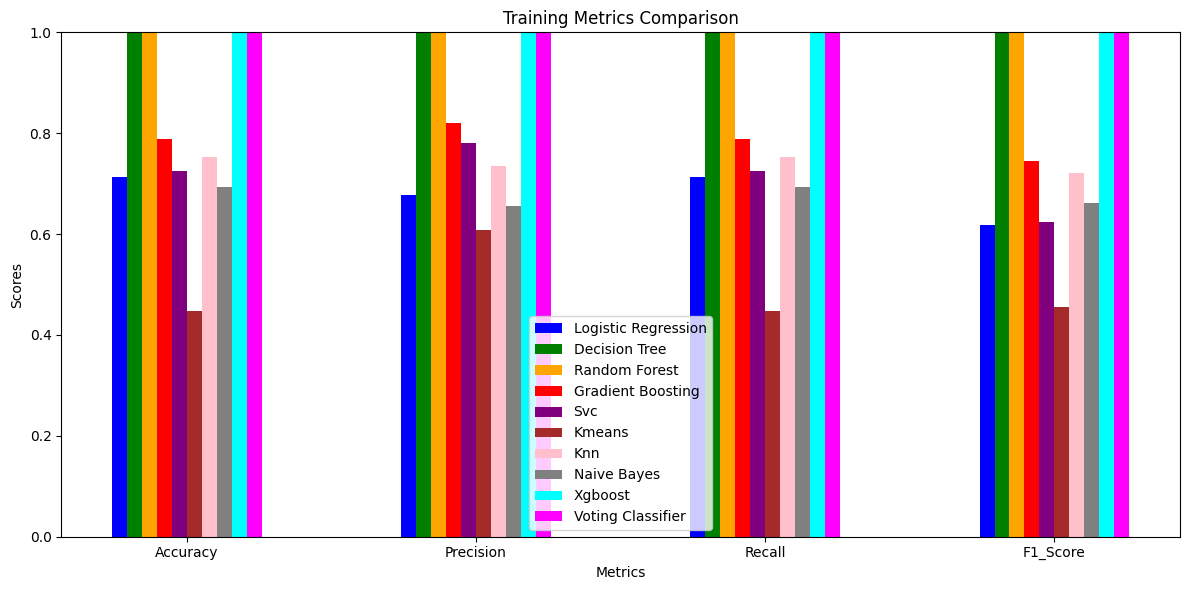

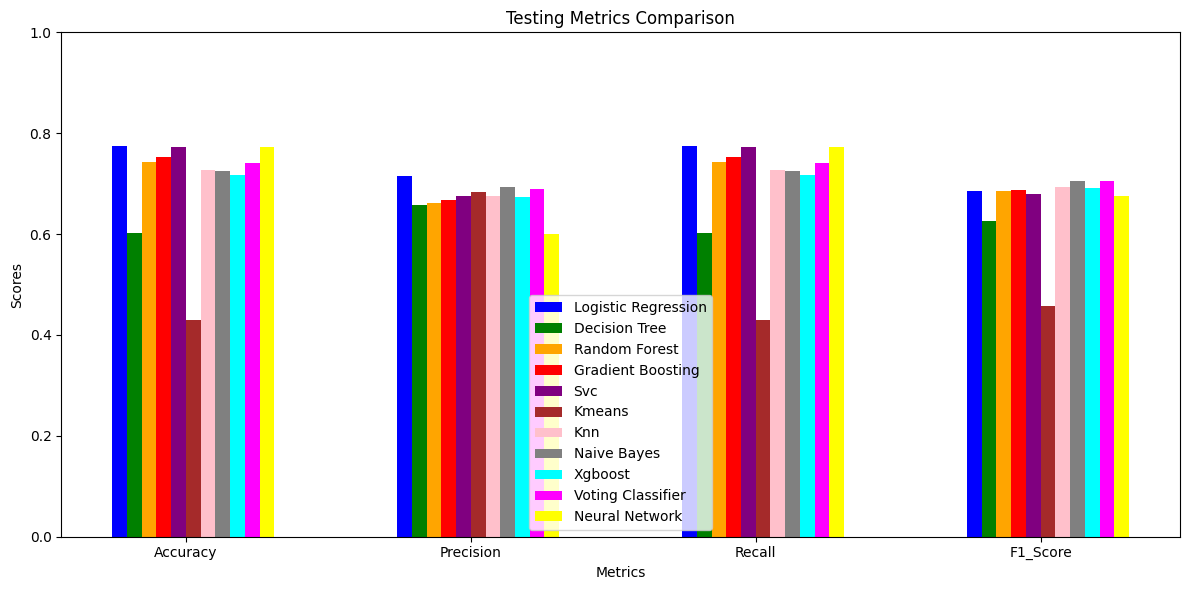

TypeError: 'float' object is not subscriptable

<Figure size 1200x600 with 0 Axes>

In [ ]:
if "Neural_Network" in models_name:
    models_name.remove("Neural_Network")
graph_models(metrics_train, metrics_test, models_name)